<img src="img/mvp_art.png" width=200 height=200 />

# Predicting the NBA's Most Valuable Player
### CMSC 320 Final Project
#### John Newhagen, Rahul Reddy, & Austin Smith
---

### Project Description:
In this project, we aim to...

Sources: https://www.basketball-reference.com/, https://basketball.realgm.com/
___

### Importing Packages and Modifying Settings
Before we can begin collecting our data, we must import the packages that will be used throughout the project.
* First, os will allow us to interact with our local files
* Secondly, pandas and numpy which will allow us to properly clean and display our data.
* Then, matplotlib and seaborn will be used for plotting our data.
* Finally, SciKit Learn and SciPy will be used to create a model for MVP Voting Share.

In [2]:
# Enter into terminal to update website: jupyter nbconvert --to html index.ipynb
import os
# Web-scraping and Data-handling packages
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import numpy as np
import unidecode as uni
# Plotting packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
register_matplotlib_converters()
import seaborn as sns
sns.set(style="darkgrid")
# Regression Modeling packages
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
# from scipy import stats

## Finding MVP Candidates
---

The first step in our process is determining who has won the NBA's Most Valuable player award and who the candidates for MVP have been since the 2000-01 NBA season. This cutoff was used as the NBA and basketball have changed over the years so constraining our data to the most recent 18 seasons should allow us to account for some of the changes while still collecting enough data to create a realistic model of MVP Voting Share.\
First we create a couple functions that will allow us to modify the table we will be scraping from basketball-reference.

In [3]:
# This function takes a pandas dataframe and renames all unnamed levels to remove them from the table
# Returns the rennamed dataframe
def rename_unnamed(df):
    for i, columns in enumerate(df.columns.levels):
        columns_new = columns.tolist()
        for j, row in enumerate(columns_new):
            if 'Unnamed: ' in row:
                columns_new[j] = ''
        df = df.rename(columns=dict(zip(columns.tolist(), columns_new)), level=i)
    return df
# This fuction takes a pandas dataframe and collapses the columns of a MultiIndexed pandas dataframe
# Returns the collapsed dataframe
def collapse_columns(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.to_series().apply(lambda x: ''.join(x))
    return df

Now that we have those, we can proceed by creating a dataframe containing the top 5 MVP candidates from 2001 to 2019 and their Rank and VotingShare.\
First, we use pandas to obtain the table containing our data, then we modify the table using the functions declared above, and finally we select the columns we want and add them to the votes dictionary with the key value of the season.

In [30]:
votes_df = pd.DataFrame()
for year in range(1981,2020):
    data = pd.read_html('https://www.basketball-reference.com/awards/awards_' + str(year) + '.html')[0]
    data = collapse_columns(rename_unnamed(data))
    data['Year'] = year
    votes_df = votes_df.append(data.loc[:4, ['Year', 'Rank', 'Player', 'Tm', 'VotingShare']])
for i, r in votes_df['Rank'].items():
    if len(str(r)) > 1:
        r = r.split()[0]
votes_df['Rank'] = votes_df['Rank'].astype(int)
votes_df.head(10)

,Year,Rank,Player,Tm,VotingShare
0,1981,1,Julius Erving,PHI,0.658
1,1981,2,Larry Bird,BOS,0.613
2,1981,3,Kareem Abdul-Jabbar,LAL,0.414
3,1981,4,Moses Malone,HOU,0.261
4,1981,5,George Gervin,SAS,0.120
0,1982,1,Moses Malone,HOU,0.735
1,1982,2,Larry Bird,BOS,0.588
2,1982,3,Julius Erving,PHI,0.294
3,1982,4,Robert Parish,BOS,0.190
4,1982,5,Gus Williams,SEA,0.167


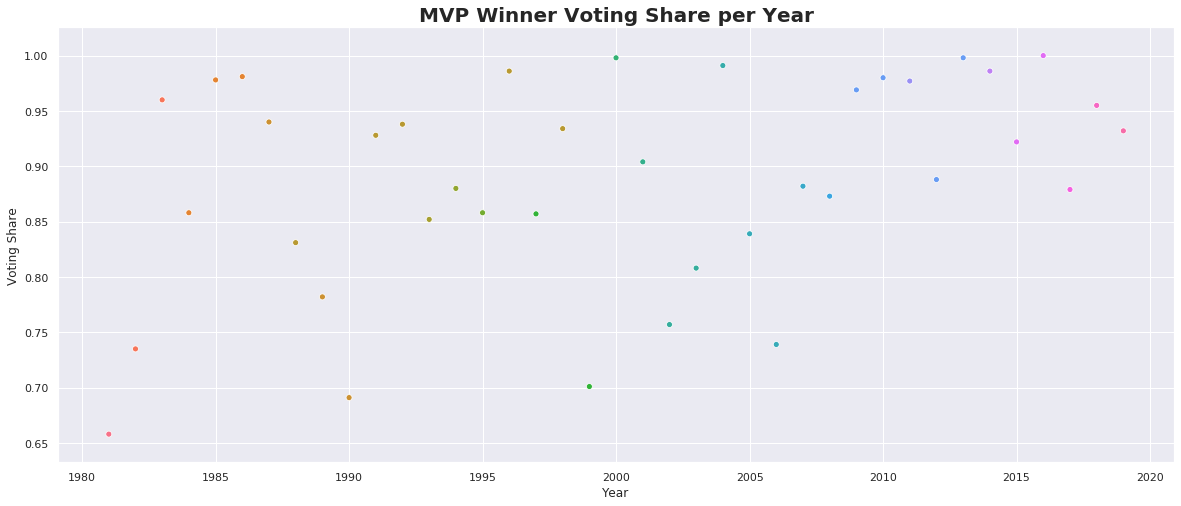

In [33]:
votes_df['Year_DT'] = [pd.to_datetime(x, format='%Y') for x in votes_df['Year']]
plt.figure(figsize=(20,8))
p = sns.scatterplot(x='Year_DT',y='VotingShare', hue='Player', data=votes_df[votes_df['Rank'] == 1], legend=False)
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('MVP Winner Voting Share per Year', fontweight="bold", fontsize=20)
plt.xlabel('Year')
plt.ylabel('Voting Share')
plt.show()

## MVP Candidate Database Builder
---

Now that we have a list of MVP candidates and their voting shares, we want to collect some statistics for all of our MVP candidates.\
We will be collecting data in terms of three separate metrics: 
* Per-Game statistics
* Team statistics
* Contribution statistics (Per-Game/Team)

In [168]:
def normalize(name, j):
    return str.lower(name.split()[1])[:1] + '/' + \
                uni.unidecode(str.lower(name.split()[1]).replace("'", "").replace('-',''))[:5] + \
                                str.lower(name.split()[0]).replace("'", "").replace('.','')[:2] + '0' + str(j)

def tabulate(row, name, year, i):
    row['Name'] = name
    if name in list(votes_df[votes_df['Year'] == year]['Player']):
        row['VotingShare'] = votes_df[votes_df['Year'] == year]['VotingShare'][i]
        row['Ranking'] = votes_df[votes_df['Year'] == year]['Rank'][i]
    row['Candidate'] = row['Name'] + ', ' + row['Season'].astype(str)
    row.replace(np.nan, 0, inplace=True)
    return row

def collect(players, teams, year, pg, tm):
    i = 0
    for (name, team_name) in zip(players, teams):
        if name != 'Magic Johnson':
            link = 'https://www.basketball-reference.com/players/' + normalize(name, 1) + '.html'
        else:
            link = 'https://www.basketball-reference.com/players/' + normalize(name, 2) + '.html'
        j = 2
        season = str(str(year-1) + '-' + str(year)[2:])
        while season not in list(pd.read_html(link)[0]['Season']):
            link = 'https://www.basketball-reference.com/players/' + normalize(name, j) + '.html'
            j += 1
        
        pergame = pd.read_html(link)[0]
        if pergame['3P%'].isnull().any():
            pergame.drop(columns='3P%',inplace=True)
        pergame.dropna(inplace=True)
        pergame['Season'] = [int(str(x).split('-')[0])+1 for x in pergame['Season']]
        pergame = pergame[pergame['Season'] == year]
        pergame.reset_index(inplace=True,drop=True)
        pergame = pergame.reindex(columns=['Season', 'Tm', 'Pos', 'G', 'MP', 'PTS', 'ORB', 'DRB', 'TRB', 'AST',
                                           'STL', 'BLK', 'TOV', 'FG%', '3P%', 'eFG%', 'FT%'])
        for col in ['G', 'MP', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%',
                    'eFG%', 'FT%']:
            pergame[col] = pergame[col].astype(float)
        pg = pg.append(tabulate(pergame, name, year, i), ignore_index=True)

        if team_name in ['NOP','NOK']: 
            team_name = 'NOH'
        elif team_name == 'BRK': 
            team_name = 'NJN'
        elif team_name in ['CHO', 'CHH']:
            team_name = 'CHA'
        elif team_name == 'PHX':
            team_name = 'PHO'
        elif team_name == 'SEA':
            team_name = 'OKC'
        elif team_name == 'VAN':
            team_name = 'MEM'
        elif team_name == 'WSB':
            team_name = 'WAS'
        team = pd.read_html('https://www.basketball-reference.com/teams/' + team_name + \
                            '/stats_per_game_totals.html')[0]
        team.replace('Season', '0000-00', inplace=True)
        team['Season'] = [int(str(x).split('-')[0])+1 for x in team['Season']]
        team = team[team['Season'] == year]
        team['Win_Pct'] = team['W'].astype(int)/team['G'].astype(int)
        team = team.reindex(columns=['Season', 'Tm', 'Win_Pct', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 
                                       'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%'])
        for col in ['Win_Pct', 'PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'FG%', '3P%', 'FT%']:
            team[col] = team[col].astype(float)
        tm = tm.append(tabulate(team, name, year, i), ignore_index=True)
        i += 1
    return (pg, tm)

In [57]:
if not(os.path.isfile('PerGame_Expanded.csv')):
    pg = pd.DataFrame()
    tm = pd.DataFrame()
    for year in range(1982,2020):
        (pg, tm) = collect(votes_df[votes_df['Year'] == year]['Player'], votes_df[votes_df['Year'] == year]['Tm'], 
                           year, pg, tm)
    pg.to_csv('PerGame_Expanded.csv')
    tm.to_csv('Team_Expanded.csv')

pg = pd.read_csv('PerGame_Expanded.csv').drop(columns=['Unnamed: 0'])
tm = pd.read_csv('Team_Expanded.csv').drop(columns=['Unnamed: 0'])

In [56]:
# Per Game Statistics
pg.head(10)

,Season,Tm,Pos,G,MP,PTS,ORB,DRB,TRB,AST,...,BLK,TOV,FG%,3P%,eFG%,FT%,Name,VotingShare,Ranking,Candidate
0,1982,HOU,C,81.0,42.0,31.1,6.9,7.8,14.7,1.8,...,1.5,3.6,0.519,0.0,0.519,0.762,Moses Malone,0.735,1,"Moses Malone, 1982"
1,1982,BOS,PF,77.0,38.0,22.9,2.6,8.3,10.9,5.8,...,0.9,3.3,0.503,0.0,0.507,0.863,Larry Bird,0.588,2,"Larry Bird, 1982"
2,1982,PHI,SF,81.0,34.4,24.4,2.7,4.2,6.9,3.9,...,1.7,2.6,0.546,0.0,0.547,0.763,Julius Erving,0.294,3,"Julius Erving, 1982"
3,1982,BOS,C,80.0,31.7,19.9,3.6,7.2,10.8,1.8,...,2.4,2.8,0.542,0.0,0.542,0.710,Robert Parish,0.190,4,"Robert Parish, 1982"
4,1982,SEA,PG,80.0,36.0,23.4,1.2,1.9,3.1,6.9,...,0.5,2.5,0.486,0.0,0.488,0.734,Gus Williams,0.167,5,"Gus Williams, 1982"
5,1983,PHI,C,78.0,37.5,24.5,5.7,9.6,15.3,1.3,...,2.0,3.4,0.501,0.0,0.501,0.761,Moses Malone,0.960,1,"Moses Malone, 1983"
6,1983,BOS,PF,79.0,37.7,23.6,2.4,8.6,11.0,5.8,...,0.9,3.0,0.504,0.0,0.512,0.840,Larry Bird,0.485,2,"Larry Bird, 1983"
7,1983,LAL,SG,79.0,36.8,16.8,2.7,5.9,8.6,10.5,...,0.6,3.8,0.548,0.0,0.548,0.800,Magic Johnson,0.406,3,"Magic Johnson, 1983"
8,1983,MIL,SG,76.0,35.7,22.5,2.5,3.2,5.8,3.9,...,0.3,2.6,0.524,0.0,0.525,0.826,Sidney Moncrief,0.301,4,"Sidney Moncrief, 1983"
9,1983,PHI,SF,72.0,33.6,21.4,2.4,4.4,6.8,3.7,...,1.8,2.7,0.517,0.0,0.518,0.759,Julius Erving,0.149,5,"Julius Erving, 1983"


In [58]:
# Team Statistics
tm.head(10)

,Season,Tm,Win_Pct,PTS,ORB,DRB,TRB,AST,STL,BLK,TOV,FG%,3P%,FT%,Name,VotingShare,Ranking,Candidate
0,1982,HOU,0.560976,105.9,17.1,27.9,45.0,24.1,7.9,5.2,16.1,0.476,0.284,0.729,Moses Malone,0.735,1,"Moses Malone, 1982"
1,1982,BOS,0.768293,112.0,15.3,30.4,45.6,25.9,8.0,6.9,17.7,0.499,0.266,0.740,Larry Bird,0.588,2,"Larry Bird, 1982"
2,1982,PHI,0.707317,111.2,12.6,29.1,41.7,27.6,10.4,7.6,18.0,0.518,0.295,0.747,Julius Erving,0.294,3,"Julius Erving, 1982"
3,1982,BOS,0.768293,112.0,15.3,30.4,45.6,25.9,8.0,6.9,17.7,0.499,0.266,0.740,Robert Parish,0.190,4,"Robert Parish, 1982"
4,1982,SEA,0.634146,107.3,13.5,31.0,44.5,25.6,8.4,5.6,16.5,0.488,0.248,0.740,Gus Williams,0.167,5,"Gus Williams, 1982"
5,1983,PHI,0.792683,112.1,16.3,31.7,47.9,24.6,9.9,7.0,19.8,0.499,0.229,0.742,Moses Malone,0.960,1,"Moses Malone, 1983"
6,1983,BOS,0.682927,112.1,15.5,30.9,46.4,27.0,9.6,6.4,18.8,0.492,0.210,0.737,Larry Bird,0.485,2,"Larry Bird, 1983"
7,1983,LAL,0.707317,115.0,15.1,29.7,44.7,30.7,10.3,5.8,19.3,0.528,0.104,0.736,Magic Johnson,0.406,3,"Magic Johnson, 1983"
8,1983,MIL,0.621951,106.6,13.4,30.2,43.6,25.8,8.1,6.5,17.6,0.489,0.219,0.753,Sidney Moncrief,0.301,4,"Sidney Moncrief, 1983"
9,1983,PHI,0.792683,112.1,16.3,31.7,47.9,24.6,9.9,7.0,19.8,0.499,0.229,0.742,Julius Erving,0.149,5,"Julius Erving, 1983"


In [59]:
# Contribution Statistics
ctb = pd.DataFrame()
ctb['Season'] = pg['Season']
ctb['Tm'] = pg['Tm']
for col in ['PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV']:
    ctb[str(col+'_CTB')] = pg[col]/tm[col]
ctb['Name'] = pg['Name']
ctb['Ranking'] = pg['Ranking']
ctb['VotingShare'] = pg['VotingShare']
ctb['Candidate'] = pg['Candidate']
ctb.head(10)

,Season,Tm,PTS_CTB,ORB_CTB,DRB_CTB,TRB_CTB,AST_CTB,STL_CTB,BLK_CTB,TOV_CTB,Name,Ranking,VotingShare,Candidate
0,1982,HOU,0.293673,0.403509,0.279570,0.326667,0.074689,0.113924,0.288462,0.223602,Moses Malone,1,0.735,"Moses Malone, 1982"
1,1982,BOS,0.204464,0.169935,0.273026,0.239035,0.223938,0.237500,0.130435,0.186441,Larry Bird,2,0.588,"Larry Bird, 1982"
2,1982,PHI,0.219424,0.214286,0.144330,0.165468,0.141304,0.192308,0.223684,0.144444,Julius Erving,3,0.294,"Julius Erving, 1982"
3,1982,BOS,0.177679,0.235294,0.236842,0.236842,0.069498,0.112500,0.347826,0.158192,Robert Parish,4,0.190,"Robert Parish, 1982"
4,1982,SEA,0.218080,0.088889,0.061290,0.069663,0.269531,0.261905,0.089286,0.151515,Gus Williams,5,0.167,"Gus Williams, 1982"
5,1983,PHI,0.218555,0.349693,0.302839,0.319415,0.052846,0.111111,0.285714,0.171717,Moses Malone,1,0.960,"Moses Malone, 1983"
6,1983,BOS,0.210526,0.154839,0.278317,0.237069,0.214815,0.197917,0.140625,0.159574,Larry Bird,2,0.485,"Larry Bird, 1983"
7,1983,LAL,0.146087,0.178808,0.198653,0.192394,0.342020,0.213592,0.103448,0.196891,Magic Johnson,3,0.406,"Magic Johnson, 1983"
8,1983,MIL,0.211069,0.186567,0.105960,0.133028,0.151163,0.185185,0.046154,0.147727,Sidney Moncrief,4,0.301,"Sidney Moncrief, 1983"
9,1983,PHI,0.190901,0.147239,0.138801,0.141962,0.150407,0.161616,0.257143,0.136364,Julius Erving,5,0.149,"Julius Erving, 1983"


## Exploratory Data Analysis
---

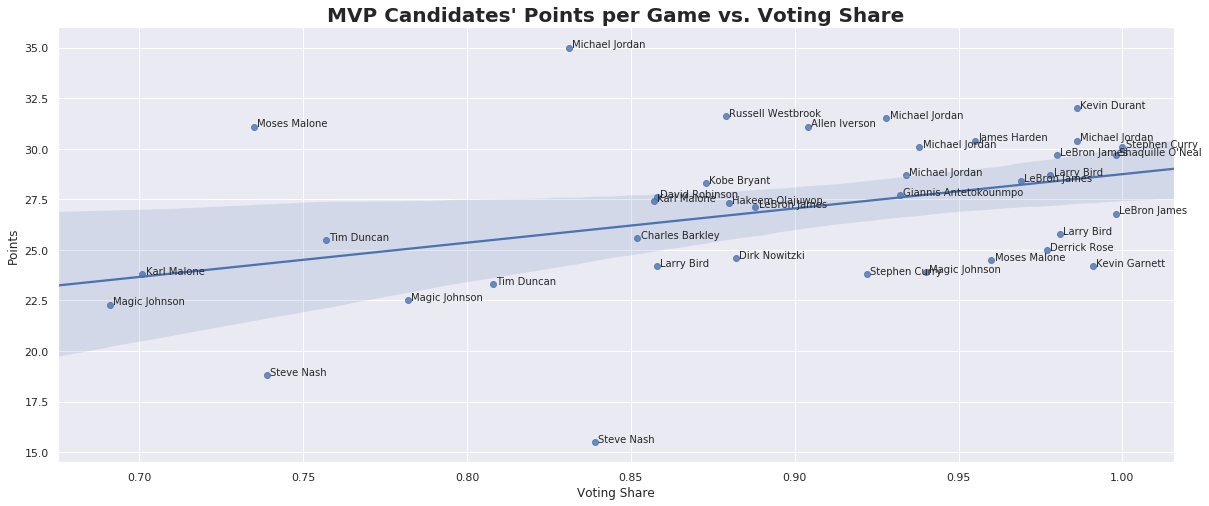

In [60]:
mvp_pg = pg[pg['Ranking'] == 1]
mvp_tm = tm[tm['Ranking'] == 1]
mvp_ctb = ctb[ctb['Ranking'] == 1]

pts = mvp_pg.loc[:, ['Name', 'VotingShare', 'PTS']]

plt.figure(figsize=(20,8))
p = sns.regplot(x='VotingShare',y='PTS',data=pts)
plt.title('MVP Candidates\' Points per Game vs. Voting Share', fontweight="bold", fontsize=20)
plt.xlabel('Voting Share')
plt.ylabel('Points')
for index, row in pts.iterrows():
    plt.annotate("".join(pts['Name'][index]), xy = (pts['VotingShare'][index] + 0.001, pts['PTS'][index]))
plt.show()

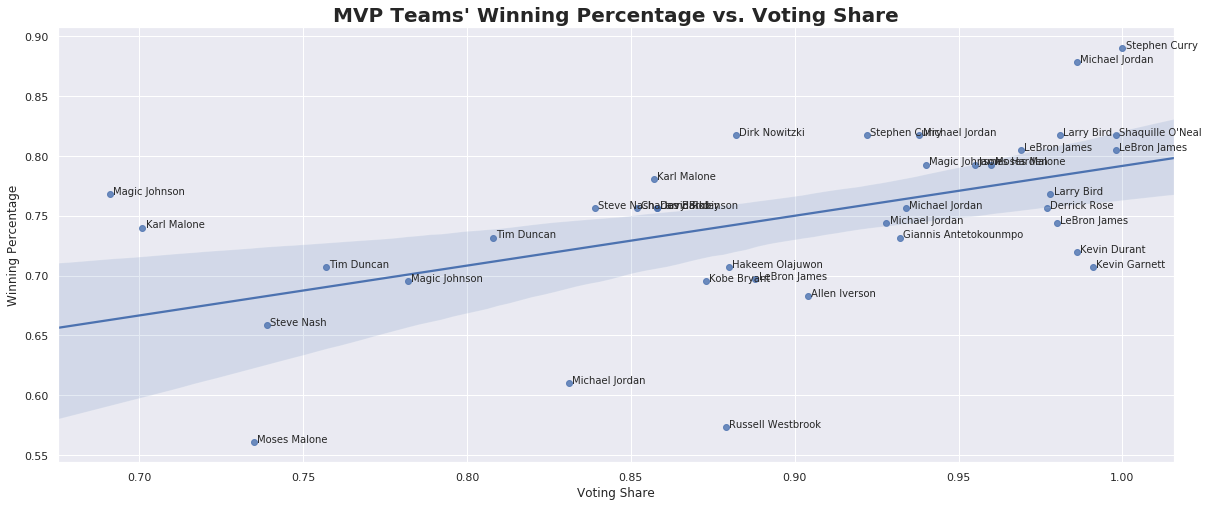

In [61]:
wins = mvp_tm.loc[:, ['Name', 'VotingShare', 'Win_Pct']]

plt.figure(figsize=(20,8))
p = sns.regplot(x='VotingShare',y='Win_Pct',data=wins)
plt.title('MVP Teams\' Winning Percentage vs. Voting Share', fontweight="bold", fontsize=20)
plt.xlabel('Voting Share')
plt.ylabel('Winning Percentage')
for index, row in pts.iterrows():
    plt.annotate("".join(wins['Name'][index]), xy = (wins['VotingShare'][index] + 0.001, wins['Win_Pct'][index]))
plt.show()

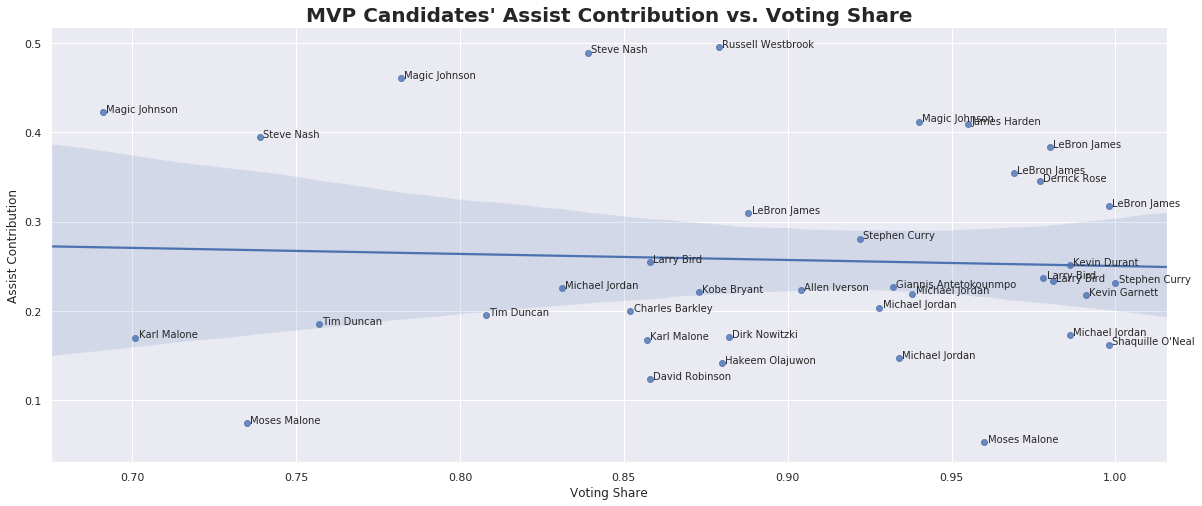

In [62]:
ast = mvp_ctb.loc[:, ['Name', 'VotingShare', 'AST_CTB']]

plt.figure(figsize=(20,8))
p = sns.regplot(x='VotingShare',y='AST_CTB',data=ast)
plt.title('MVP Candidates\' Assist Contribution vs. Voting Share', fontweight="bold", fontsize=20)
plt.xlabel('Voting Share')
plt.ylabel('Assist Contribution')
for index, row in pts.iterrows():
    plt.annotate("".join(ast['Name'][index]), xy = (ast['VotingShare'][index] + 0.001, ast['AST_CTB'][index]))
plt.show()

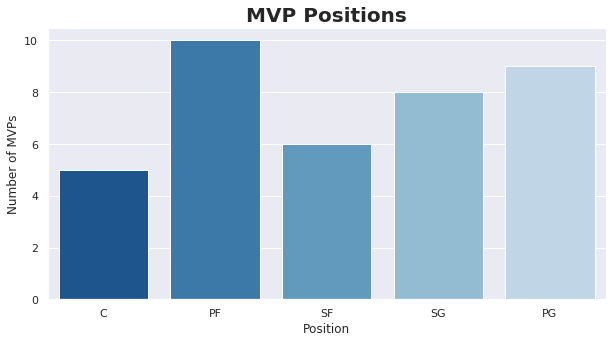

In [63]:
pos = mvp_pg['Pos']
pos_map = {'C': 0, 'PF': 0, 'SF': 0, 'SG': 0, 'PG': 0}
for p in list(pos):
    pos_map[p] += 1
pos = pd.DataFrame([pos_map]).melt()
plt.figure(figsize=(10,5))
p = sns.barplot(x='variable',y='value',data=pos, palette=sns.color_palette('Blues_r'))
plt.title('MVP Positions', fontweight="bold", fontsize=20)
plt.xlabel('Position')
plt.ylabel('Number of MVPs')
plt.show()

### Finding Correlations
---

In [64]:
def hmap(df, variables):
    corr = df.corr()[variables]
    corr = corr.take([len(df.corr())-1])
    plt.figure(figsize=(20,8))
    ax = plt.gca()
    sns.heatmap(data=corr, cmap=cmap, square=True, linewidths=.5, ax=ax, annot=True, cbar=False, vmin=0, vmax=.2)
    plt.yticks(rotation=0)
    return plt

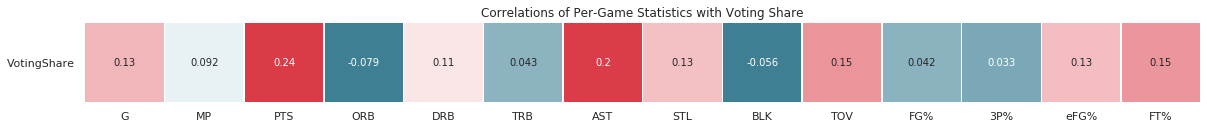

In [65]:
cmap = sns.diverging_palette(220,10, as_cmap=True)
plt = hmap(pg.drop(columns=['Season', 'Tm', 'Candidate', 'Ranking', 'Name', 'Pos']), 
     ['G','MP','PTS','ORB','DRB','TRB','AST','STL','BLK','TOV','FG%','3P%','eFG%','FT%'])
plt.title('Correlations of Per-Game Statistics with Voting Share')
plt.show()

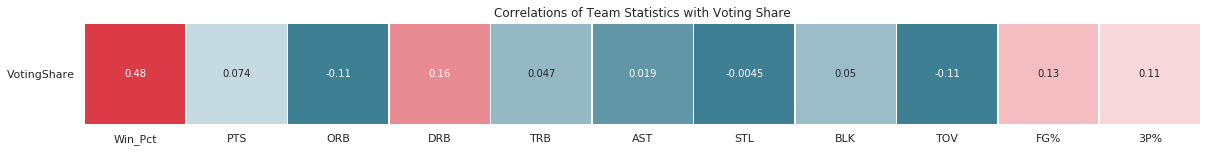

In [66]:
plt = hmap(tm.drop(columns=['Season', 'Tm', 'Candidate', 'Ranking', 'Name']), 
           ['Win_Pct','PTS','ORB','DRB','TRB','AST','STL','BLK','TOV','FG%','3P%'])
plt.title('Correlations of Team Statistics with Voting Share')
plt.show()

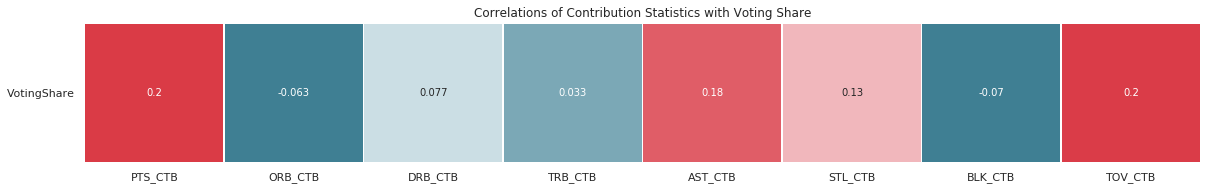

In [67]:
plt = hmap(ctb.drop(columns=['Season', 'Tm', 'Candidate', 'Ranking', 'Name']), 
           ['PTS_CTB','ORB_CTB','DRB_CTB','TRB_CTB','AST_CTB','STL_CTB','BLK_CTB','TOV_CTB'])
plt.title('Correlations of Contribution Statistics with Voting Share')
plt.show()

## Creating a Model
---

In [164]:
def select(pg, tm, ctb, lists):
    pg_select = pg.copy(deep=True)[lists[0]]
    tm_select = tm.copy(deep=True)[lists[1]]
    ctb_select = ctb.copy(deep=True)[lists[2]]
    return pd.concat([pg_select, tm_select, ctb_select], axis=1)

def rsd_plot(x, rsd):
    plt.figure(figsize=(20,10))
    sns.violinplot(x=x,y=rsd)
    plt.title('Residuals vs. MVP Ranking', fontweight="bold", fontsize=20)
    plt.xlabel('MVP Ranking')
    plt.ylabel('Residual')
    plt.show()

def predict(name, team_name, year, reg, lists):
    pergame = pd.DataFrame()
    team = pd.DataFrame()
    (pergame, team) = collect([name], [team_name], year, pergame, team)
    
    ctb = pd.DataFrame()
    ctb['Season'] = pergame['Season']
    ctb['Tm'] = pergame['Tm']
    for col in ['PTS', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV']:
        ctb[str(col+'_CTB')] = pergame[col]/tm[col]
    ctb['Name'] = pergame['Name']
    ctb['Candidate'] = pergame['Candidate']
    
    select_test = select(pergame, team, ctb, lists)
    y_pred = reg.predict(select_test)[0]
    if y_pred < 0:
        return 0
    else:
        return y_pred

0.3554188574232947


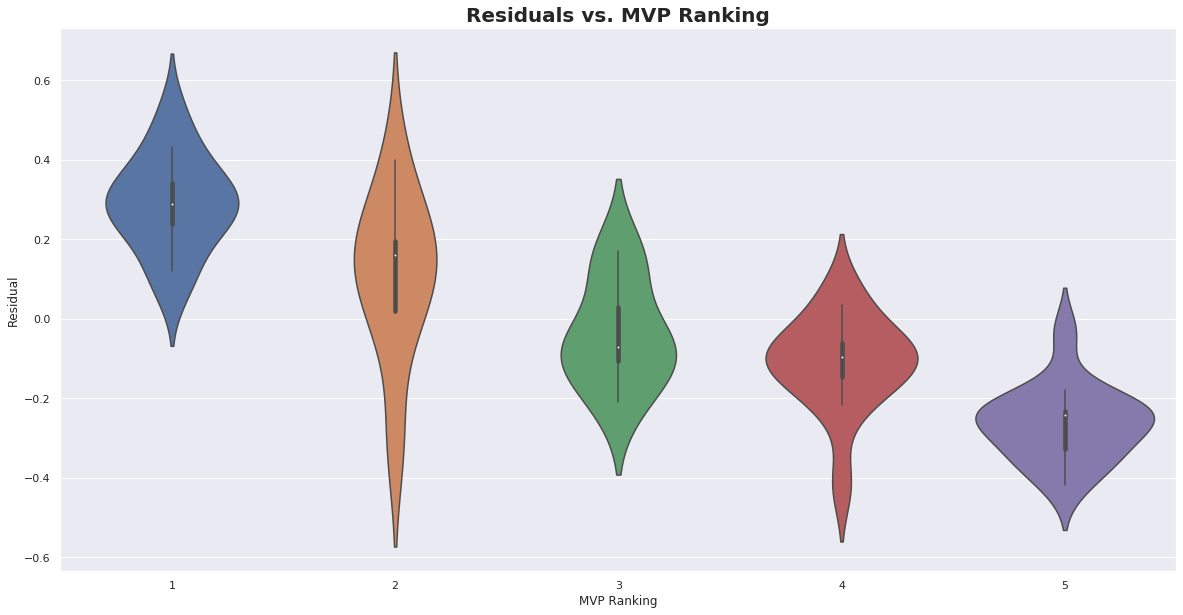

In [180]:
pg_list = ['Ranking', 'G', 'PTS', 'AST', 'eFG%', 'FT%']
tm_list = ['Win_Pct']
ctb_list = ['TOV_CTB']
# pg_list = ['Ranking', 'G','MP','PTS','ORB','DRB','TRB','AST','STL','BLK','TOV','FG%','3P%','eFG%','FT%']
# tm_list = ['Win_Pct','PTS','ORB','DRB','TRB','AST','STL','BLK','TOV','FG%','3P%']
# ctb_list = ['PTS_CTB','ORB_CTB','DRB_CTB','TRB_CTB','AST_CTB','STL_CTB','BLK_CTB','TOV_CTB']
X = select(pg, tm, ctb, [pg_list, tm_list, ctb_list])
y = pg['VotingShare']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train = X_train.drop(columns=['Ranking'])

parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
lin_reg = GridSearchCV(estimator=linear_model.LinearRegression(), param_grid=parameters, cv=5, iid=False)
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test.drop(columns=['Ranking']))
def limit(x):
    if x < 0:
        return 0
    else:
        return x
y_pred = [limit(x) for x in y_pred]
print(r2_score(y_test, y_pred))
rsd_plot(X_test['Ranking'], y_test - y_pred)

0.3133047884713357


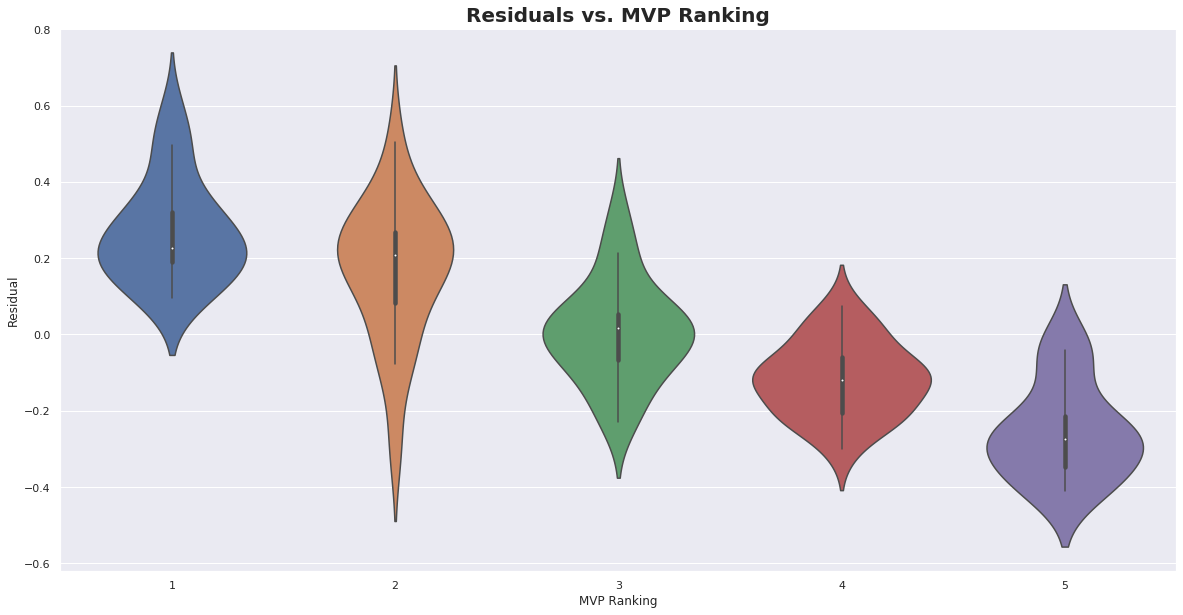

In [94]:
parameters = {'n_estimators': [10, 50, 100], 'criterion': ['mse', 'mae'], 'max_depth': [2, 4, 8],
             'min_samples_split': [2, 4, 8], 'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True, False]}
rfr_reg = GridSearchCV(estimator=RandomForestRegressor(), param_grid=parameters, cv=5, iid=False)
rfr_reg.fit(X_train, y_train)
y_pred = rfr_reg.predict(X_test.drop(columns=['Ranking']))
print(r2_score(y_test, y_pred))
rsd_plot(X_test['Ranking'], y_test - y_pred)

## Testing the Model
---

In [169]:
tables = pd.read_html('https://basketball.realgm.com/nba/players/2019')
table = tables[12].copy(deep=True)[tables[12]['GP'] >= 41]
j = 0
for i, x in table.iterrows():
    if len(x['Teams']) > 3:
        table.drop(table.index[j], inplace=True)
        j -= 1
    j += 1
players = table[['Player', 'Teams']].sample(n=5)
pg_list = ['G', 'PTS', 'AST', 'eFG%', 'FT%']
tm_list = ['Win_Pct']
ctb_list = ['TOV_CTB']
lists = [pg_list, tm_list, ctb_list]
predictions = pd.DataFrame()
for (name, team) in zip(players['Player'], players['Teams']):
    print(name)
    prediction = predict(name, team, 2019, lin_reg, lists)
    predictions = predictions.append(pd.DataFrame([[name, prediction]], columns=['Player', 
                        'Predicted VotingShare']), sort=False).reset_index()[['Player', 'Predicted VotingShare']]
predictions

Richaun Holmes
Tyus Jones
Josh Hart
Jeremy Lamb
Dorian Finney-Smith


,Player,Predicted VotingShare
0,Richaun Holmes,0
1,Tyus Jones,0
2,Josh Hart,0
3,Jeremy Lamb,0
4,Dorian Finney-Smith,0
